## Exploring FastAI Transformations

### Get set up

`ImageList` can generate a list of the images in a folder. Let's start by accessing a single image to explore transforms.

In [1]:
from fastai.vision import ImageList

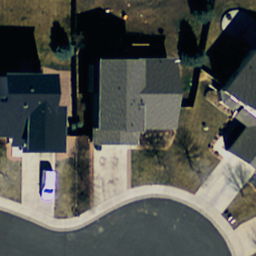

In [2]:
imgPath = r'C:\EsriTraining\IMAP\Output\DLTrainingSamples'
imgList = ImageList.from_folder(imgPath)
img = imgList.open(imgList.items[88])
img

### Transformations

Each transformation will have an argument `p`. This is the probability that the transformation is applied to the image chip. Notes:
- 1 means always apply.
- 0 means never apply.
- 0.5 means it's a 50-50 chance.

This notebook explores commonly used transformations: `rotate`, `brightness`, `contrast`, `zoom`, and `crop`.

#### Rotate

`ImageList` reads the input image chip. Transformations are available through fastai.vision's `transform` module.

In [3]:
from fastai.vision.transform import rotate

`rotate` rotates the input image.  Read more about this transformation in the [help documentation](https://docs.fast.ai/vision.augment.html#rotate).

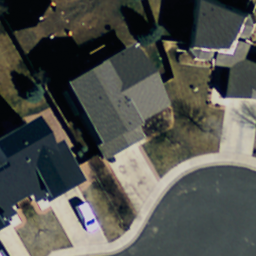

In [4]:
tfms = [rotate(degrees=30, p=1)]
img.apply_tfms(tfms)

#### Brightness

In [5]:
from fastai.vision.transform import brightness

`brightness` adjusts the brightness of the image. Read more about this transformation in the [help documentation](https://docs.fast.ai/vision.augment.html#brightness). Notes:
- You can provide a single value for the `change` parameter to specify the brightness applied.
- You can also provide a range. `[0.1, 0.9]` is a minimum brightness of 0.1 and a maximum brightness of 0.9. A random value within the range is selected.
- A change of 0 transforms the image to black
- A change of 1 transforms the image to white
- A change of 0.5 does not transform the image

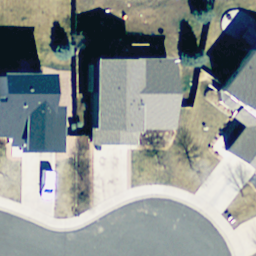

In [6]:
tfms = [brightness(change=[0.7, 0.9], p=1)]
img.apply_tfms(tfms)

#### Contrast

In [7]:
from fastai.vision.transform import contrast

`contrast` adjusts the contrast of the image. Read more about this transformation in the [help documentation](https://fastai1.fast.ai/vision.transform.html#_contrast). Notes:
- Set the `scale` parameter to a list containing the minimum and maximum contrast level. A random value within the range is selected.
- A value of 0 transforms the image to grey.
- A value of 1 transforms the image to super-contrast.

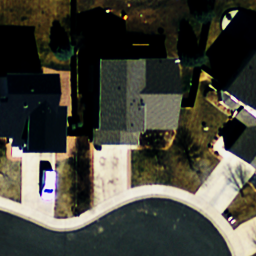

In [8]:
tfms = [contrast(scale=[1.75, 2], p=1)]
img.apply_tfms(tfms)

#### Zoom

In [9]:
from fastai.vision.transform import zoom

`zoom` zooms in on a focal point on the image, typically the center. read more about this transformation in the [help documentation](https://fastai1.fast.ai/vision.transform.html#_zoom). Notes:
- `scale` parameter determines the zoom level.
    - A value of 1 means no zoom.
    - A value larger than 1 zooms in
    - A value smaller than 1 zooms out, repeating the image to fill pixels.
- `row_pct` and `col_pct` determine the focal point.

Example of zooming in:

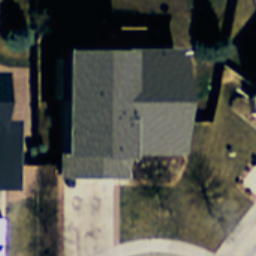

In [10]:
tfms = [zoom(scale=1.5, row_pct=0.3, col_pct=0.6, p=1)]
img.apply_tfms(tfms)

Example of zooming out:

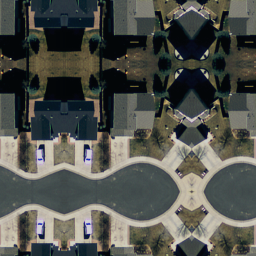

In [11]:
tfms = [zoom(scale=0.5, p=1)]
img.apply_tfms(tfms)

#### Crop

In [12]:
from fastai.vision.transform import crop

`crop` is like `zoom`, but the subset of the image occupies all pixels instead of repeating them when zoomed out. `size=150` means that the output image is now 150 pixels x 150 pixels.

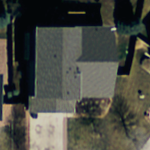

In [13]:
tfms = [crop(size=150, row_pct=0.3, col_pct=0.6, p=1)]
img.apply_tfms(tfms)

### Stitch transformations together

The code below brings `rotate`, `contrast`, `crop` into a single variable for use.

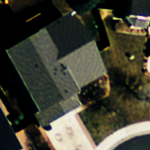

In [14]:
tfms = [rotate(degrees=30, p=1), contrast(scale=[1.75, 2], p=1), crop(size=150, row_pct=0.3, col_pct=0.6, p=1)]
img.apply_tfms(tfms)

### Save the transformation as a JSON file

In ArcGIS Pro, you can use a JSON file to supply these transforms into the Train Deep Learning Model geprpocessing tool. The code below shows how to take the work done in the notebook and create a file for use in ArcGIS Pro. 

The [help documentation](https://pro.arcgis.com/en/pro-app/latest/tool-reference/image-analyst/train-deep-learning-model.htm#GUID-B4B43917-0A4A-413C-BE33-CD156B22DFDA:~:text=Custom%20augmentation%20parameters) shows an example of what this JSON file needs to be.

The code below writes this to a JSON file: 
```python
{"Training": {"rotate": {"degrees": 30, "p": 1},
            "contrast": {"scale": [1.75, 2], "p": 1},
            "crop": {"size": 150, "row_pct": 0.3, "col_pct": 0.6, "p": 1}},
"Validation": {"crop": {"size": 150, "row_pct": 0.3, "col_pct": 0.6, "p": 1}}}
```

#### Import libraries

In [15]:
import json, os
from pprint import pprint

#### Populate training dictionary with all tranforms

In [16]:
trainingDict = {}
for i in range(len(tfms)):
    tfm = tfms[i]
    trainingDict.update({tfm.__name__:tfm.kwargs})
    trainingDict[tfm.__name__]['p'] = (tfm.p)
pprint(trainingDict)

{'contrast': {'p': 1, 'scale': [1.75, 2]},
 'crop': {'col_pct': 0.6, 'p': 1, 'row_pct': 0.3, 'size': 150},
 'rotate': {'degrees': 30, 'p': 1}}


#### Populate the validation dictionary

Validation data should have minimal transforms. The only transformations that should exist are those that resize the image. Since the training data is cropped, reducing the size, so should the validation data.

In [17]:
validationDict = {}
for i in range(len(tfms)):
    tfm = tfms[i]
    if tfm.__name__ in ['crop']:
        validationDict.update({tfm.__name__:tfm.kwargs})
        validationDict[tfm.__name__]['p'] = (tfm.p)
pprint(validationDict)

{'crop': {'col_pct': 0.6, 'p': 1, 'row_pct': 0.3, 'size': 150}}


#### Create the final dictionary to write to JSON

In [18]:
data = {'Training': trainingDict, 'Validation':validationDict}
pprint(data)

{'Training': {'contrast': {'p': 1, 'scale': [1.75, 2]},
              'crop': {'col_pct': 0.6, 'p': 1, 'row_pct': 0.3, 'size': 150},
              'rotate': {'degrees': 30, 'p': 1}},
 'Validation': {'crop': {'col_pct': 0.6, 'p': 1, 'row_pct': 0.3, 'size': 150}}}


#### Write the JSON file

In [19]:
jsonFile = 'transforms.json'
with open(os.path.join(imgPath, jsonFile), 'w') as f:
    json.dump(data, f)